In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
import random
import spacy
import time
import nltk
import copy
import string
import pdb
import concurrent.futures
import pickle
SEED = 7

In [ ]:
nltk.download('punkt')

In [ ]:
TRAIN_POS_PATH = "./aclImdb/train/pos/"
TRAIN_NEG_PATH = "./aclImdb/train/neg/"
TEST_POS_PATH = "./aclImdb/test/pos/"
TEST_NEG_PATH = "./aclImdb/test/neg/"

In [ ]:
train_split = int(20000/2)

train_pos_paths = glob(os.path.join(TRAIN_POS_PATH, "*.txt"))
train_neg_paths = glob(os.path.join(TRAIN_NEG_PATH, "*.txt"))
test_pos_paths = glob(os.path.join(TEST_POS_PATH, "*.txt"))
test_neg_paths = glob(os.path.join(TEST_NEG_PATH, "*.txt"))

random.Random(SEED).shuffle(train_pos_paths)
random.Random(SEED).shuffle(train_neg_paths)

val_pos_paths = train_pos_paths[train_split:]
val_neg_paths = train_neg_paths[train_split:]

train_pos_paths = train_pos_paths[:train_split]
train_neg_paths = train_neg_paths[:train_split]

train_paths = train_pos_paths+train_neg_paths
val_paths = val_pos_paths+val_neg_paths
test_paths = test_pos_paths+test_neg_paths

random.Random(SEED).shuffle(train_paths)
random.Random(SEED).shuffle(val_paths)
random.Random(SEED).shuffle(test_paths)

In [ ]:
print ("length of the training data: {}".format(len(train_paths)))
print ("length of the validation data: {}".format(len(val_paths)))
print ("length of the test data: {}".format(len(test_paths)))

In [ ]:
def dataset_collection(paths):
    data = pd.DataFrame()
    id_list = []
    label_list = []
    text_list = []
    
    for path in tqdm(paths):
        file_name = path.split('/')[-1].split('.')[0]
        id_list.append(file_name.split('_')[0])
#         label_list.append(int(file_name.split('_')[1])-1)
        label_list.append(1 if int(file_name.split('_')[1])>5 else 0)
        with open(path, 'r') as f:
            text_list.append(f.read())
    
    data['ID'] = id_list
    data['text'] = text_list
    data['label'] = label_list    
    return data

In [ ]:
training_dataset = dataset_collection(train_paths[:])
val_dataset = dataset_collection(val_paths[:])
test_dataset =dataset_collection(test_paths[:])

### Tokenize

In [ ]:
tokenizer = spacy.load('en_core_web_sm')
punctuations = string.punctuation

def tokenize_spacy(sent):
    tokens = tokenizer(sent)
    return [token.text.lower() for token in tokens if token.text not in punctuations]

def tokenize_nltk(sent):
    tokens = nltk.word_tokenize(sent)
    return [token.lower() for token in tokens if token not in punctuations]

def tokenize_space(sent):
    tokens = sent.split(' ')
    return [token.lower() for token in tokens if token not in punctuations]

def tokenize_dataset(dataset, mode='spacy'):
    data_id = []
    data_text = []
    data_label = []
    all_tokens = []
    for idx in tqdm(range(len(dataset))):
        if mode == 'spacy':
            tokens = tokenize_spacy(dataset.iloc[idx]['text'].replace('<br /><br />', ''))
        elif mode == 'nltk':
            tokens = tokenize_nltk(dataset.iloc[idx]['text'].replace('<br /><br />', ''))
        elif mode == 'space':
            tokens = tokenize_space(dataset.iloc[idx]['text'].replace('<br /><br />', ''))
        else:
            raise ValueError("Unrecognized mode!")
        data_id.append(dataset.iloc[idx]['ID'])
        data_text.append(tokens)
        data_label.append(dataset.iloc[idx]['label'])
        all_tokens += tokens
    return data_id, data_text, data_label, all_tokens

In [ ]:
# from multiprocessing import Pool
# def parallel_tokenize_dataset(df, partitions=8, processes=8):
#     # calculate features in parallel by splitting the dataframe into partitions and using parallel processes
# #     pdb.set_trace()
#     pool = Pool(processes)
    
#     df_split = np.array_split(df, partitions, axis=0)  # split dataframe into partitions column wise
    
#     df = pool.map(tokenize_dataset, df_split)
#     pool.close()
#     pool.join()
    
#     return df


_, train_tokens, train_label, all_tokens = tokenize_dataset(training_dataset, 'spacy')
_, val_tokens, val_label, _ = tokenize_dataset(val_dataset, 'spacy')
_, test_tokens, test_label, _ = tokenize_dataset(test_dataset,  'spacy')

In [2]:
train_tokens=pickle.load(open('./train_tokens.p', 'rb'))
train_label=pickle.load(open('./train_label_bi.p', 'rb'))
all_tokens=pickle.load(open('./all_tokens.p', 'rb'))

val_tokens = pickle.load(open('./val_tokens.p', 'rb'))
val_label = pickle.load(open('./val_label_bi.p', 'rb'))

test_tokens = pickle.load(open('./test_tokens.p', 'rb'))
test_label = pickle.load(open('./test_label_bi.p', 'rb'))

In [3]:
def to_N_gram(dataset, N):
    dataset_n_gram = []
    all_tokens = []
    for data in tqdm(dataset):
        n_gram = []
        for idx in range(len(data)-N+1):
#             pdb.set_trace()
            n_gram.append([' '.join(data[idx:idx+N])][0])
        dataset_n_gram.append(n_gram)
        all_tokens += n_gram
    return dataset_n_gram, all_tokens

train_tokens_bi, all_tokens_bi = to_N_gram(train_tokens, 2)
val_tokens_bi, _ = to_N_gram(val_tokens, 2)
test_tokens_bi, _ = to_N_gram(test_tokens, 2)

100%|██████████| 25000/25000 [00:03<00:00, 7866.48it/s]


In [4]:
from collections import Counter

VOCABULARY_SIZE = 20000
PAD_IDX = 0
UNK_IDX = 1 
MAX_SENTENCE_LENGTH = 400

def build_vocab(all_tokens, VOCABULARY_SIZE=40000):
    token_counter = Counter(all_tokens)
    print ("Total number of tokens: ", len(token_counter))
    words, freq = zip(*token_counter.most_common(VOCABULARY_SIZE))
    id2token = ['<pad>', '<unk>']+list(words)
    token2id = dict(zip(id2token, range(2+len(words))))
    return id2token, token2id

id2token, token2id = build_vocab(all_tokens_bi, VOCABULARY_SIZE)

Total number of tokens:  1203340


In [5]:
def token2id_dataset(text_dataset, id2token=id2token, token2id=token2id):
    indices_data=[]
    for text in text_dataset:
        idx_list = [token2id[word] if word in token2id else UNK_IDX for word in text]
#         idx_list = idx_list+[PAD_IDX]*(PAD_LEN-len(idx_list))
        indices_data.append(idx_list)
    return indices_data

train_indices = token2id_dataset(train_tokens_bi)
val_indices = token2id_dataset(val_tokens_bi)
test_indices = token2id_dataset(test_tokens_bi)


print ("Train dataset size is {}".format(len(train_indices)))
print ("Val dataset size is {}".format(len(val_indices)))
print ("Test dataset size is {}".format(len(test_indices)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000


In [6]:
MAX_SENTENCE_LENGTH = 400

import numpy as np
import torch
from torch.utils.data import Dataset
from torch.optim import lr_scheduler

class IMDB_Dataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list, target_list, max_length):
        """
        @param data_list: list of newsgroup tokens 
        @param target_list: list of newsgroup targets 

        """
        self.data_list = data_list
        self.target_list = target_list
        self.MAX_SENTENCE_LENGTH = max_length
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        
        token_idx = self.data_list[key][:self.MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        return [token_idx, len(token_idx), label]

def newsgroup_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list = []
    label_list = []
    length_list = []
    for datum in batch:
#         pdb.set_trace()
        label_list.append(datum[2])
        length_list.append(datum[1])
    # padding
#     for datum in batch:
        padded_vec = np.pad(np.array(datum[0]), 
                                pad_width=((0, MAX_SENTENCE_LENGTH-datum[1])), 
                                mode="constant", constant_values=0)
        data_list.append(padded_vec)
    return [torch.from_numpy(np.array(data_list)), torch.LongTensor(length_list), torch.LongTensor(label_list)]

# create pytorch dataloader
#train_loader = NewsGroupDataset(train_data_indices, train_targets)
#val_loader = NewsGroupDataset(val_data_indices, val_targets)
#test_loader = NewsGroupDataset(test_data_indices, test_targets)

BATCH_SIZE = 32
train_dataset = IMDB_Dataset(train_indices, train_label, MAX_SENTENCE_LENGTH)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

val_dataset = IMDB_Dataset(val_indices, val_label, MAX_SENTENCE_LENGTH)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

test_dataset = IMDB_Dataset(test_indices, test_label, MAX_SENTENCE_LENGTH)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)

In [7]:
# First import torch related libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

class N_grams(nn.Module):
    """
    BagOfWords classification model
    """
    def __init__(self, vocab_size, emb_dim):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        """
        super(N_grams, self).__init__()
        # pay attention to padding_idx 
        print ("Construct model with vocab size {} and emb dim {}".format(vocab_size, emb_dim))
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.linear = nn.Linear(emb_dim,2)
    
    def forward(self, data, length):
        """
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        out = self.embed(data)
        out = torch.sum(out, dim=1)
        out /= length.view(length.size()[0],1).expand_as(out).float()
     
        # return logits
        out = self.linear(out.float())
        return F.log_softmax(out, dim=1)

emb_dim = 300
model = N_grams(len(id2token), emb_dim)

Construct model with vocab size 20002 and emb dim 300


In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [9]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25, early_stopping_patience=2):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    prev_best_acc = 0.0
    count = 0
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
#         print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                if scheduler != None:
                    scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            total = 0

            # Iterate over data.
            for data_batch, length_batch, label_batch in dataloaders[phase]:
#                 pdb.set_trace()
                data_batch = data_batch.to(device)
                length_batch = length_batch.to(device)
                label_batch = label_batch.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    output_batch = model(data_batch, length_batch)
                    pred_batch = output_batch.max(1, keepdim=True)[1]
#                     _, preds = torch.max(outputs, 1)
                    loss = criterion(output_batch, label_batch)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                total += label_batch.size(0)
                running_loss += loss.item() * data_batch.size(0)
                running_corrects += pred_batch.eq(label_batch.view_as(pred_batch)).sum().item()

            epoch_loss = running_loss / total
            epoch_acc = running_corrects *100 / total
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                val_loss.append(epoch_loss)
                val_acc.append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            if phase == 'val' and epoch_acc > prev_best_acc:
                prev_best_acc = epoch_acc
                count = 0
            else:
                count += 1
        if count > early_stopping_patience:
            break

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    log = {'train_loss': train_loss, "train_acc": train_acc, "val_loss": val_loss, "val_acc": val_acc}
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, log

In [10]:
def test_hyper_para_on_val(num_epochs=50, emb_dim=200, vocabulary_size=20000, annealing=False, opm="Adam", lr=0.01, sent_length=400):
    print ('-'*100)
    print ('Embed dim: {} ; Vocab size: {}; Optim: {}; LR: {}; Annealing: {}; Sent_length: {}'.format(emb_dim, vocabulary_size, opm, lr, annealing, sent_length))
    print ('-'*100)
#     if vocabulary_size != 40000:
    global MAX_SENTENCE_LENGTH
    global all_tokens_bi
    global train_tokens_bi
    global val_tokens_bi
    global test_tokens_bi

    MAX_SENTENCE_LENGTH = sent_length
#     pdb.set_trace()
    id2token, token2id = build_vocab(all_tokens_bi, vocabulary_size)
    
    train_indices = token2id_dataset(train_tokens_bi, id2token=id2token, token2id=token2id)
    val_indices = token2id_dataset(val_tokens_bi, id2token=id2token, token2id=token2id)
    test_indices = token2id_dataset(test_tokens_bi, id2token=id2token, token2id=token2id)

    train_dataset = IMDB_Dataset(train_indices, train_label, sent_length)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=True)

    val_dataset = IMDB_Dataset(val_indices, val_label, sent_length)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=True)

    test_dataset = IMDB_Dataset(test_indices, test_label, sent_length)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=False)
        
    
    dataloaders = {'train': train_loader, 'val': val_loader}
    model = N_grams(len(id2token), emb_dim)
    criterion = torch.nn.NLLLoss() 
    
    if opm == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif opm == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    if annealing:
        scheduler = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.5)
    else:
        scheduler = None
    model = model.to(device)
    model, log = train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs)
    
    print ("Finished!")
    
    return model, log

### Ablation Study

In [12]:
# emb_size_test = [100, 200, 300, 400, 500]
# for i in emb_size_test:
#     test_hyper_para_on_val(emb_dim=i)

# vocab_size_test = [20000, 30000, 40000, 50000, 60000]
# for i in vocab_size_test:
#     test_hyper_para_on_val(vocabulary_size=i)

test_hyper_para_on_val(opm='SGD')
test_hyper_para_on_val(opm='Adam')

# lr_test = [0.1, 0.05, 0.01, 0.005, 0.001, 0.0005]
# for i in lr_test:
#     test_hyper_para_on_val(lr=i, annealing=False)
    
# lr_test = [0.1, 0.05, 0.01, 0.005, 0.001, 0.0005]
# for i in lr_test:
#     test_hyper_para_on_val(lr=i, annealing=False)
    
# sent_length = [200, 300, 400, 500, 600, 700]
# for i in sent_length:
#     test_hyper_para_on_val(sent_length=i)


----------------------------------------------------------------------------------------------------
Embed dim: 200 ; Vocab size: 20000; Optim: SGD; LR: 0.01; Annealing: False; Sent_length: 400
----------------------------------------------------------------------------------------------------
Total number of tokens:  1203340
Construct model with vocab size 20002 and emb dim 200
Epoch 0/49
train Loss: 0.7221 Acc: 52.2500
val Loss: 0.6840 Acc: 53.7400
Epoch 1/49
train Loss: 0.6841 Acc: 55.6750
val Loss: 0.7148 Acc: 50.3000
Epoch 2/49
train Loss: 0.6770 Acc: 57.3050
val Loss: 0.6759 Acc: 55.6200
Epoch 3/49
train Loss: 0.6687 Acc: 59.3600
val Loss: 0.6522 Acc: 62.6600
Epoch 4/49
train Loss: 0.6587 Acc: 61.0900
val Loss: 0.6500 Acc: 60.5000
Epoch 5/49
train Loss: 0.6480 Acc: 62.4300
val Loss: 0.6496 Acc: 61.6800
Training complete in 0m 27s
Best val Acc: 62.660000
Finished!
----------------------------------------------------------------------------------------------------
Embed dim: 200 ; 

(N_grams(
   (embed): Embedding(20002, 200, padding_idx=0)
   (linear): Linear(in_features=200, out_features=20, bias=True)
 ),
 {'train_loss': [0.41321656382083893,
   0.16808615270853042,
   0.07610243571996689],
  'train_acc': [80.62, 93.84, 97.62],
  'val_loss': [0.32054340047836305, 0.37680809078216554, 0.5433329518318176],
  'val_acc': [86.6, 85.36, 84.0]})

## Results on validation set

|Tokenize schemes|n-gram n:|vocabulary size|embedding size|Optimizer|Learning Rate|Annealing|Validation Accuracy|
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|Spacy|2|40000|400|Adam|0.01|No|87.52|
|NLTK|2|40000|400|Adam|0.01|No|86.64|
|SPACE|2|40000|400|Adam|0.01|No|86.52|
|Spacy|2|40000|400|Adam|0.01|No|87.52|
|Spacy|3|40000|400|Adam|0.01|No|81.66|
|Spacy|4|40000|400|Adam|0.01|No|78.34|
|Spacy|2|40000|100|Adam|0.01|No|87.74|
|Spacy|2|40000|200|Adam|0.01|No|87.96|
|Spacy|2|40000|300|Adam|0.01|No|87.16|
|Spacy|2|40000|400|Adam|0.01|No|87.46|
|Spacy|2|40000|500|Adam|0.01|No|86.10|
|Spacy|2|20000|200|Adam|0.01|No|86.76|
|Spacy|2|30000|200|Adam|0.01|No|84.98|
|Spacy|2|40000|200|Adam|0.01|No|86.3|
|Spacy|2|50000|200|Adam|0.01|No|86.12|
|Spacy|2|60000|200|Adam|0.01|No|86.30|
|Spacy|2|20000|200|SGD|0.01|No|65.4|
|Spacy|2|20000|200|Adam|0.01|No|86.68|
|Spacy|2|30000|300|Adam|0.1|No|83.54|
|Spacy|2|30000|300|Adam|0.05|No|85.3|
|Spacy|2|30000|300|Adam|0.01|No|86.22|
|Spacy|2|30000|300|Adam|0.005|No|86.36|
|Spacy|2|30000|300|Adam|0.001|No|86.96|
|Spacy|2|30000|300|Adam|0.0005|No|87.12|
|Spacy|2|30000|300|Adam|0.1|Yes|85.98|
|Spacy|2|30000|300|Adam|0.05|Yes|86.52|
|Spacy|2|30000|300|Adam|0.01|Yes|87.16|
|Spacy|2|30000|300|Adam|0.005|Yes|86.36|
|Spacy|2|30000|300|Adam|0.001|Yes|87.36|
|Spacy|2|30000|300|Adam|0.0005|Yes|86.2|

### N-grams N search

In [ ]:
# N=3
# Rerun the function to_N_gram(dataset, N) for N=3 and 4
# 3009792 different tokens in total
def to_N_gram(dataset, N):
    dataset_n_gram = []
    all_tokens = []
    for data in tqdm(dataset):
        n_gram = []
        for idx in range(len(data)-N+1):
#             pdb.set_trace()
            n_gram.append([' '.join(data[idx:idx+N])][0])
        dataset_n_gram.append(n_gram)
        all_tokens += n_gram
    return dataset_n_gram, all_tokens

train_tokens_bi, all_tokens_bi = to_N_gram(train_tokens, 3)
val_tokens_bi, _ = to_N_gram(val_tokens, 3)
test_tokens_bi, _ = to_N_gram(test_tokens, 3)

In [ ]:
vocab_size_test = [90000, 100000, 110000, 120000]
for i in vocab_size_test:
    test_hyper_para_on_val(emb_dim=400, vocabulary_size=i)

In [ ]:
# N=4
# Rerun the function to_N_gram(dataset, N) for N=3 and 4
# 4113005 different tokens in total

train_tokens_bi, all_tokens_bi = to_N_gram(train_tokens, 4)
val_tokens_bi, _ = to_N_gram(val_tokens, 4)
test_tokens_bi, _ = to_N_gram(test_tokens, 4)

In [ ]:
vocab_size_test = [170000, 180000, 190000, 200000]
for i in vocab_size_test:
    test_hyper_para_on_val(vocabulary_size=i)

### Testing

In [13]:
train_tokens_bi, all_tokens_bi = to_N_gram(train_tokens, 2)
val_tokens_bi, _ = to_N_gram(val_tokens, 2)
test_tokens_bi, _ = to_N_gram(test_tokens, 2)

model, log = test_hyper_para_on_val(num_epochs=50, emb_dim=200, vocabulary_size=20000, annealing=True, opm="Adam", lr=0.001, sent_length=700)

100%|██████████| 25000/25000 [00:03<00:00, 7835.18it/s]


----------------------------------------------------------------------------------------------------
Embed dim: 200 ; Vocab size: 20000; Optim: Adam; LR: 0.001; Annealing: True; Sent_length: 700
----------------------------------------------------------------------------------------------------
Total number of tokens:  1203340
Construct model with vocab size 20002 and emb dim 200
Epoch 0/49
train Loss: 0.7139 Acc: 65.2250
val Loss: 0.5815 Acc: 75.2000
Epoch 1/49
train Loss: 0.4625 Acc: 83.5400
val Loss: 0.4061 Acc: 84.6400
Epoch 2/49
train Loss: 0.3192 Acc: 88.8100
val Loss: 0.3549 Acc: 84.8800
Epoch 3/49
train Loss: 0.2487 Acc: 91.5550
val Loss: 0.3161 Acc: 86.9000
Epoch 4/49
train Loss: 0.2046 Acc: 93.6400
val Loss: 0.3091 Acc: 87.5200
Epoch 5/49
train Loss: 0.1848 Acc: 94.3150
val Loss: 0.3048 Acc: 87.3200
Epoch 6/49
train Loss: 0.1671 Acc: 94.9800
val Loss: 0.3034 Acc: 87.4800
Training complete in 0m 38s
Best val Acc: 87.520000
Finished!


In [14]:
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data, lengths, labels in loader:
        data_batch, length_batch, label_batch = data, lengths, labels
        outputs = model(data_batch, length_batch)
        predicted = outputs.max(1, keepdim=True)[1]
        
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
#     print (total)
    return (100 * correct / total)

In [15]:
model = model.to('cpu')
test_model(test_loader, model)

86.788

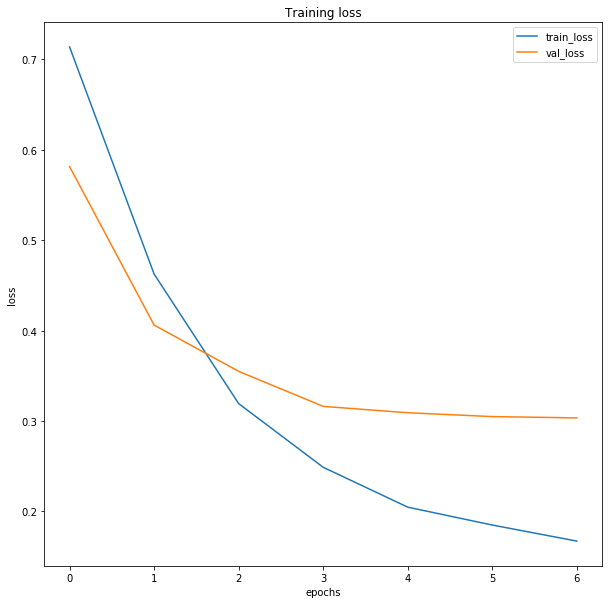

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,10))
for key, curve in log.items():
    if 'loss' in key:
        x = np.arange(len(curve))
        plt.plot(x, curve, label=key)
plt.legend(loc='best')
plt.title('Training loss')
plt.ylabel('loss')
plt.xlabel('epochs')
# plt.show()
plt.savefig('Training loss.png')

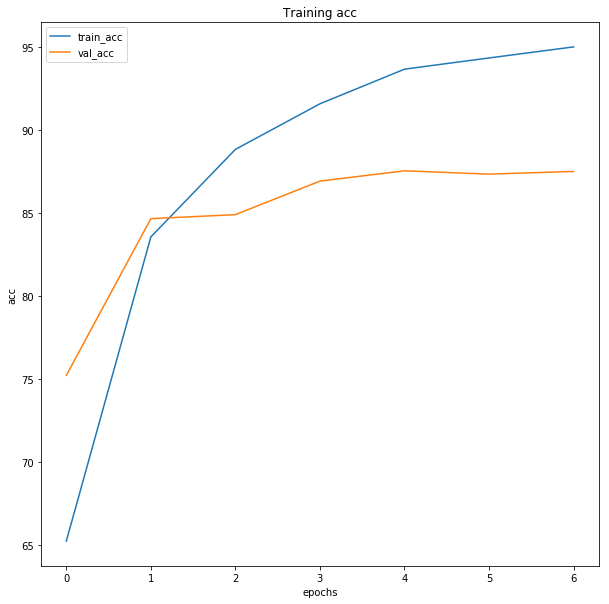

In [17]:
plt.figure(figsize=(10,10))
for key, curve in log.items():
    if 'acc' in key:
        x = np.arange(len(curve))
        plt.plot(x, curve, label=key)
plt.legend(loc='best')
plt.title('Training acc')
plt.ylabel('acc')
plt.xlabel('epochs')
# plt.show()
plt.savefig('Training acc.png')

# Run for another time, so the results might be slightly different